In [155]:
import matplotlib.pyplot as plt
import pandas
%matplotlib inline

### Redefining Cancer Treatment

##### Dan Lipert for Incubit

This is an exploration and solution for Kaggle machine learning problem at https://www.kaggle.com/c/msk-redefining-cancer-treatment. This notebook was created by Dan Lipert as an exercise for Incubit. 

First, we'll explore the data sets provided. Then we'll examine the machine learning implications of the data, and come up with a model to provide a solution.

To begin, let's load the data:

In [156]:
train_text = pandas.read_csv('C:/incubit/training_text', sep='\|\|', header=None, skiprows=1, names=['ID', 'Text'])
test_text = pandas.read_csv('C:/incubit/test_text', sep='\|\|', header=None, skiprows=1, names=['ID', 'Text'])
train_variants = pandas.read_csv('C:/incubit/training_variants')
test_variants = pandas.read_csv('C:/incubit/test_variants')

print("Loaded %s training entries" % len(train_text))
print("Loaded %s test entries" % len(test_text))

C:\Users\dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.
C:\Users\dan\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  


Loaded 3321 training entries
Loaded 5668 test entries


### Investigating the Variants

Let's take a look at the variant data - it consists of an ID, a Gene notation indicating the type of gene, and a description of the variant. We also have the target data for this exercise, the classification of the mutation. As we learn in the exercise description on Kaggle, these classes have no relationship to each other, but are rather notations to obscure the data set used for the exercise. Therefore we can assume the 1-9 label is not any kind of continuous range but rather a class label.

In [157]:
print(train_variants)

        ID    Gene             Variation  Class
0        0  FAM58A  Truncating Mutations      1
1        1     CBL                 W802*      2
2        2     CBL                 Q249E      2
3        3     CBL                 N454D      3
4        4     CBL                 L399V      4
5        5     CBL                 V391I      4
6        6     CBL                 V430M      5
7        7     CBL              Deletion      1
8        8     CBL                 Y371H      4
9        9     CBL                 C384R      4
10      10     CBL                 P395A      4
11      11     CBL                 K382E      4
12      12     CBL                 R420Q      4
13      13     CBL                 C381A      4
14      14     CBL                 P428L      5
15      15     CBL                 D390Y      4
16      16     CBL  Truncating Mutations      1
17      17     CBL                 Q367P      4
18      18     CBL                 M374V      5
19      19     CBL                 Y371S

Let's take a look of the frequency of the different classes. Unusual patterns are indicators of predicting data.  As shown, 7 is the most common, and 5, 8, and 9 are very uncommon. Hopefully, the training data set is representative of the test data set and we can find what elements in the data are responsible.

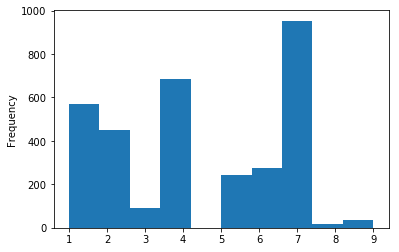

In [158]:
train_variants['Class'].plot.hist()

What about the gene labels? Here, we look to see the range in terms of different genes, and how they are distributed throughout the training data.

### Gene Labels

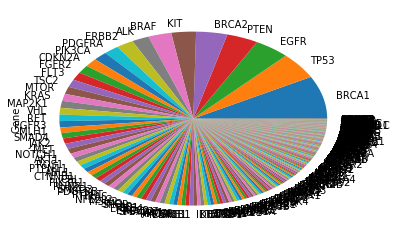

In [159]:
gene_counts = train_variants['Gene'].value_counts()
gene_counts.plot.pie()

The gene labels are clearly not distributed evenly, with BRCA1 being much more common than most other genes, and 50% of the training data is made of a handful of genes. However, we don't know what type of relationships the gene labels have to each other. For example, it may be true that BRCA1 and BRCA2 share some common features. Or perhaps the letters are abbreviations and each character may be important. Some google searching reveals that BRCA1 stands for "Breast Cancer 1" so these letters are indeed labels, and not indicative of a feature space. We'll utilize these gene names as individual labels. Further research may reveal additional information based on relationships between these genes. 

Lets see if there is a relationship between individual gene labels and the target class

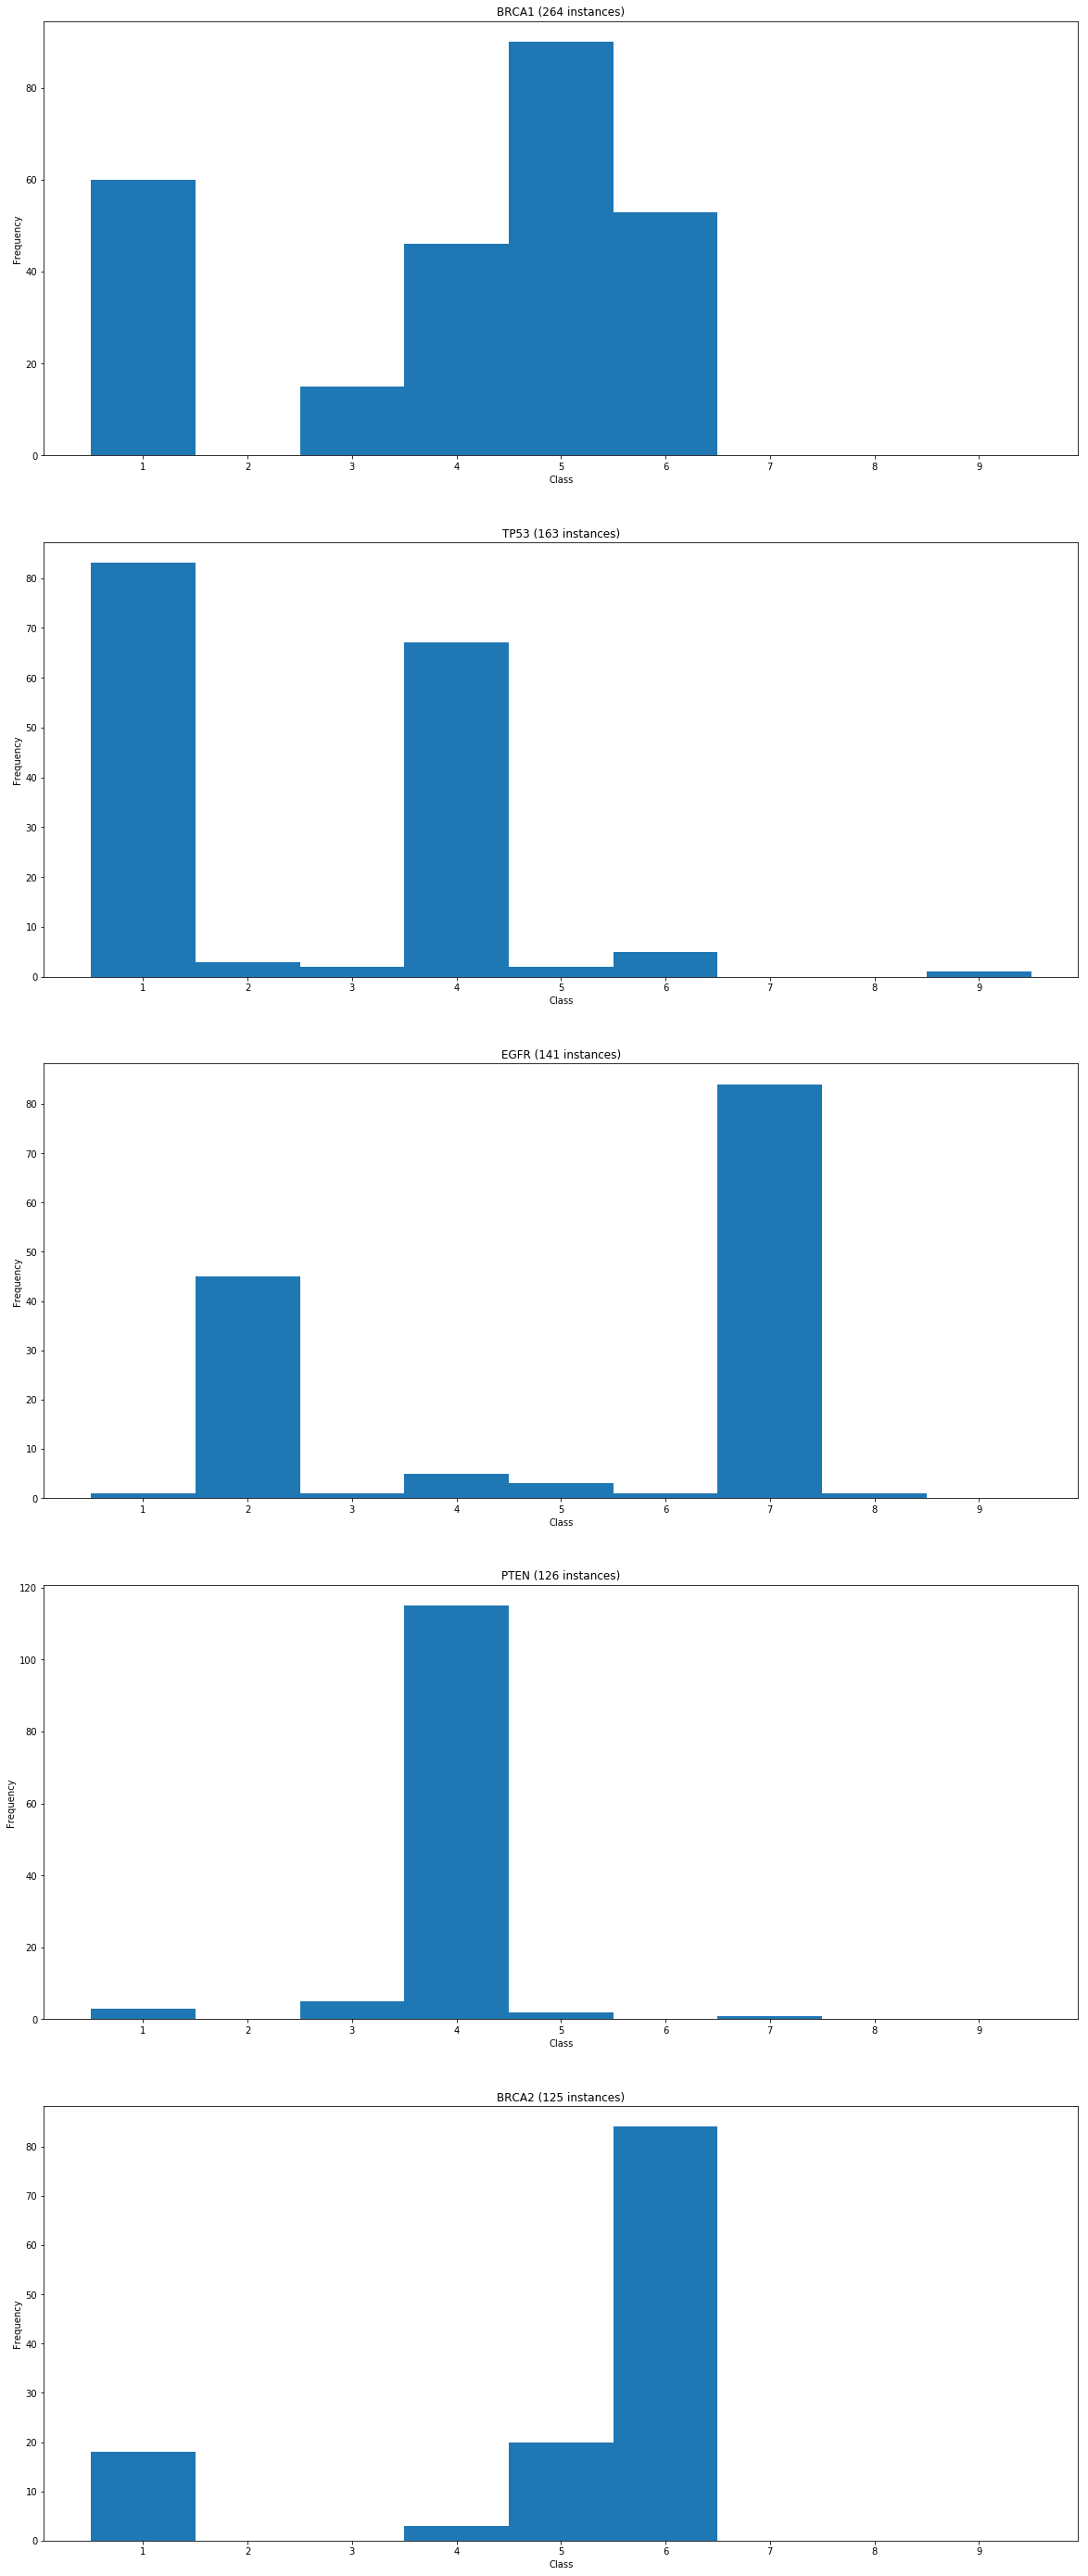

In [160]:
num_genes = 5
fig, axs = plt.subplots(num_genes, 1)
gene_names_by_freq = gene_counts.axes
for i in range(num_genes):
    each_gene = gene_counts.index[i]
    gene_variants = train_variants.loc[train_variants['Gene'] == each_gene]
    axs[i].xaxis.set_ticks(range(10))
    axs[i].set_title('%s (%s instances)' % (each_gene, gene_counts[i]))
    axs[i].set_xlabel('Class')
    gene_variants['Class'].plot.hist(ax=axs[i], range=[0, 9], figsize=(20, 50), align='left', rwidth=1, bins=range(1,11))

These distributions look promising. Here we can see that for specific genes, the distribution of the target class is very different. At a baseline, this information can indicate the probability of a particular class given a gene.

Let's investigate the other column in this data set, the variation for each gene.

### Gene Variants

Truncating Mutations    93
Deletion                74
Amplification           71
Fusions                 34
Overexpression           6
G12V                     4
E17K                     3
Q61H                     3
Q61R                     3
T58I                     3
Q61L                     3
G67R                     2
P34R                     2
E542K                    2
F384L                    2
Q22K                     2
S222D                    2
TMPRSS2-ETV1 Fusion      2
G35R                     2
A146T                    2
G12A                     2
T73I                     2
V321M                    2
T167A                    2
G13C                     2
Q209L                    2
G12D                     2
T286A                    2
E330K                    2
F28L                     2
                        ..
S46N                     1
Q12Y                     1
Y236S                    1
R71G                     1
G14V                     1
E709V                    1
R

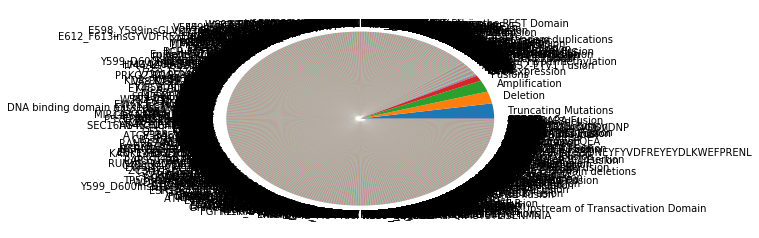

In [161]:
train_variants['Variation'].value_counts().plot.pie()
print(train_variants['Variation'].value_counts())

Clearly there are many different possible variations. Here there are a sizeable chunk of variations with english language descriptions, with the remainder mostly some kind of notation or label. Some searching online reveals that this notation indicates the change in molecule and the location the change takes place. This gives us an opportunity to process this data further to separate it and use the location and molecule change seperately in our model. 

Let's see if there is a relationship between individual gene labels and the variant information.

In [162]:
for gene in ['BRCA1', 'TP53', 'EGFR', 'PTEN', 'BRCA2', 'KIT', 'BRAF', 'ALK']:
    gene_variants = train_variants.loc[train_variants['Gene'] == gene]
    print('Most common variants for %s' % gene)
    print(gene_variants['Variation'].value_counts())

Most common variants for BRCA1
P1812S    1
S4F       1
S1715R    1
W1782C    1
L1780P    1
L1854P    1
A1708E    1
H1402Y    1
T1852S    1
C1787S    1
P1771L    1
S59R      1
D1778N    1
A1843P    1
S1140G    1
T1691I    1
I1807S    1
S1655F    1
F1695L    1
W1718C    1
K1702E    1
A1843T    1
T1691K    1
L246V     1
D1739V    1
E1250K    1
E1214K    1
R1753T    1
R1699W    1
E1682K    1
         ..
G1743R    1
S1841N    1
E143K     1
L1705P    1
F1704S    1
V11A      1
S1301R    1
T1720I    1
R170Q     1
H1746Q    1
L1657P    1
R1699Q    1
A1669S    1
P1637L    1
H1805P    1
K50L      1
V191D     1
W1837G    1
V1810G    1
V1713A    1
K65M      1
M1775K    1
I21V      1
M1783L    1
M1411T    1
W1718L    1
E1282V    1
K45N      1
H41R      1
S1486C    1
Name: Variation, Length: 264, dtype: int64
Most common variants for TP53
G244S    1
I195T    1
R282Q    1
L348F    1
K292T    1
R181L    1
S215G    1
R158C    1
R280K    1
P278L    1
V197E    1
S241Y    1
V157D    1
G245S    1
R337H    1

Unfortunately, it seems that the variants don't really repeat in relation to the genes. Let's look at the more common, "vague" descriptors such as "Truncating Mutations".

In [163]:
common_variations = ['Truncating Mutations', 'Deletion', 'Amplification', 'Fusions']
for variation in common_variations:
    class_by_variant = train_variants.loc[train_variants['Variation'] == variation]
    print('Classes for variant %s' % variation)
    print(class_by_variant['Class'].value_counts())

Classes for variant Truncating Mutations
1    89
6     2
4     1
2     1
Name: Class, dtype: int64
Classes for variant Deletion
1    57
4    16
6     1
Name: Class, dtype: int64
Classes for variant Amplification
7    40
2    21
6    10
Name: Class, dtype: int64
Classes for variant Fusions
2    31
1     2
8     1
Name: Class, dtype: int64


There seems to be a solid relationship between these common variations and the target class. Also note that there are related variants scattered throughout the dataset, with notations such as "ins" and "del". We'll assume that there is predictive information contained within these entries, but for now we'll group them together under the label "Other" for simplicity as we work with the simple "A123C" style mutations.

We'll start examining the simple mutations by checking the location.

### Gene Variant Location

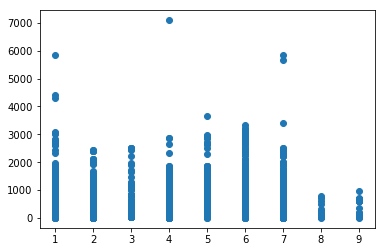

In [164]:
import re

# get the number in the variant
locations = [[re.sub("\D", "", v), c] for v, c in zip(train_variants['Variation'], train_variants['Class'])];

# remove some outliers and empty data
locations_filtered = [[int(l[0]), l[1]] for l in locations if l[0] is not '' and int(l[0]) < 10000]

plt.scatter([l[1] for l in locations_filtered],[l[0] for l in locations_filtered])

Looks like there is some useful information here, but probably doesn't have great predictive power. That's okay though, we can still use the information contained within by ensembling the various models we construct together.  Let's now take a look at the molecular information.

### Gene Variant Models

In [165]:
# lets select the simple variations
variations = [[v, c] for v, c in zip(train_variants['Variation'], train_variants['Class']) if any(char.isdigit() for char in v)];

# Filter out the longer notations that contain numbers, such as "E746_T751delinsVA"
simple_variations = [[v, c] for v, c in variations if len(v) <= 6]
print(simple_variations)
print(len(simple_variations))

[['W802*', 2], ['Q249E', 2], ['N454D', 3], ['L399V', 4], ['V391I', 4], ['V430M', 5], ['Y371H', 4], ['C384R', 4], ['P395A', 4], ['K382E', 4], ['R420Q', 4], ['C381A', 4], ['P428L', 5], ['D390Y', 4], ['Q367P', 4], ['M374V', 5], ['Y371S', 4], ['H94Y', 6], ['C396R', 4], ['G375P', 4], ['S376F', 4], ['P417A', 4], ['H398Y', 4], ['S2G', 4], ['Y846C', 4], ['C228T', 7], ['H412Y', 4], ['H876Q', 4], ['P704S', 4], ['C250T', 7], ['G1809R', 4], ['G1809K', 4], ['D1709E', 1], ['D1709A', 1], ['E1705A', 4], ['D1810A', 4], ['E1705K', 4], ['T1365M', 4], ['V648G', 1], ['T844M', 4], ['A707T', 1], ['R1343L', 4], ['A209T', 1], ['Y280H', 1], ['D927G', 4], ['N510K', 1], ['F248S', 1], ['L708P', 1], ['V995M', 4], ['Y412F', 1], ['F74S', 1], ['R1040L', 1], ['R453C', 1], ['R1209W', 4], ['A1022E', 4], ['Q984K', 4], ['T605M', 1], ['K218T', 1], ['N1125I', 4], ['Y35C', 7], ['Y35N', 7], ['Y35H', 7], ['L234fs', 1], ['L1273F', 4], ['P284L', 2], ['Q276*', 7], ['T286A', 7], ['T283A', 7], ['I290A', 2], ['I290R', 2], ['A77S', 7]

In [166]:
# lets see how large the set of first and last letter is:
first_letters = set([s[0] for s in [v for v, c in simple_variations]])
print(first_letters)

last_letters = set([s[-1] for s in [v for v, c in simple_variations]])
print(last_letters)

# less than the full alphabet at least... perhaps they come in common pairs
pairs = set([s[0] + s[-1] for s in [v for v, c in simple_variations]])
print(pairs)
print('Possible pairs: %s Actual pairs:%s' % (len(first_letters) * len(last_letters), len(pairs)))

{'V', 'W', 'D', 'Y', 'H', 'S', 'T', 'N', 'F', 'P', 'C', 'K', 'R', 'A', 'G', 'I', 'Q', 'E', 'M', 'L'}
{'V', 'W', 'Y', 'I', 'R', 'l', '*', 'S', '7', 'G', 's', 'Q', 'E', '5', 'D', 'H', 'N', 'C', 'M', 'L', 'T', 'F', 'P', 'A', 'K'}
{'TP', 'YS', 'VA', 'ND', 'NT', 'IT', 'C5', 'KM', 'RT', 'FI', 'PT', 'MK', 'GC', 'TI', 'WL', 'MI', 'W*', 'AH', 'EL', 'DY', 'QR', 'Rs', 'Es', 'AD', 'HN', 'AP', 'RW', 'RP', 'YD', 'IL', 'RL', 'LI', 'Ts', 'NK', 'TR', 'NA', 'FC', 'KN', 'SC', 'YL', 'WA', 'Ll', 'CG', 'QL', 'AF', 'RA', 'QC', 'TS', 'EV', 'RI', 'PS', 'VK', 'RD', 'AE', 'NY', 'Ss', 'IV', 'GF', 'YW', 'A7', 'SR', 'MV', 'LN', 'GN', 'LA', 'ML', 'KD', 'CY', 'QY', 'RQ', 'DG', 'PR', 'RM', 'KA', 'HP', 'CF', 'QP', 'TL', 'IF', 'YH', 'ST', 'VG', 'KQ', 'WR', 'DI', 'CA', 'SP', 'SD', 'IW', 'KI', 'LF', 'LP', 'CR', 'SE', 'KR', 'Il', 'YN', 'VI', 'YF', 'LT', 'AG', 'WV', 'HD', 'VE', 'NR', 'IS', 'E*', 'PH', 'LR', 'SG', 'MA', 'Sl', 'GD', 'DA', 'IA', 'VR', 'FA', 'PM', 'FG', 'TM', 'WC', 'NP', 'VM', 'SL', 'HM', 'SA', 'MR', 'EQ', 'RC'

Here we've seen that the starting and ending letters are a subset of the possible characters, and the pair of the first and last letter doesn't seem to appear in specific combinations. We'll therefore use them seperately as two types of features. Notations that don't fit the simple variant we've described above will for now be classified as "Other".

In [167]:
train_variants['First'] = None
train_variants['Last'] = None
for i in range(len(train_variants)):
    v = train_variants['Variation'][i]
    if len(v) > 6:
        first_letter_class = 'Other'
        last_letter_class = 'Other'
    else:
        first_letter_class = v[0]
        last_letter_class = v[-1]
    train_variants.set_value(i, 'First', first_letter_class)
    train_variants.set_value(i, 'Last', last_letter_class)

Now we'll use these designations to create features. Because this information is in the form of letters, we'll have to transform the data so that it can work with our machine learning algorithms. To do this, we encode each letter in a bitfield, where a 1 indicates the entry has a given letter in a given position.

In [168]:
from sklearn.ensemble import RandomForestClassifier

letter_forest = RandomForestClassifier(n_estimators = 100)

# Select only the features
f_enc = pandas.get_dummies(train_variants, columns=['First', 'Last'])
f_enc = f_enc.loc[:,'First_A':]

# letter_forest.fit(f_enc, train_variants['Class'])

We've created our model, now let's examine the performance:

In [169]:
from sklearn import cross_validation
import sklearn
import numpy

cv = cross_validation.KFold(len(train_variants), n_folds=3)
results = []

for train_range, test_range in cv:
    test_forest = forest.fit(f_enc.loc[train_range], train_variants['Class'][train_range])
    p = test_forest.predict_proba(f_enc.loc[test_range])
    log_loss = sklearn.metrics.log_loss(train_variants['Class'][test_range], p, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)

print(results)
print("Results: %s" % str(numpy.array(results).mean()))

Log loss: 4.84520356419
Log loss: 4.92661890598
Log loss: 7.18767452515
[4.8452035641896822, 4.926618905979721, 7.1876745251532466]
Results: 5.65316566511


Not a great result to say the least, but perhaps it will aid us on edge cases when we combine the classifiers. Let's try in the location data and see what results that gives us. 

In [170]:
l_value, l_class = zip(*locations)

# l_value is sparse, because not all of the gene variants fit the A123B pattern. 
# We can do things to handle sparse data more effectively, but for now we'll just set empty data to zero

l_value = [v if v != '' else 0 for v in l_value]

l_value = numpy.asarray(l_value)
l_class = numpy.asarray(l_class)
print(l_value)
print(l_class)

forest = RandomForestClassifier(n_estimators = 100)

cv = cross_validation.KFold(len(l_value), n_folds=3)
results = []

for train_range, test_range in cv:
    test_forest = forest.fit(l_value[:, None][train_range], l_class[train_range])
    p = test_forest.predict_proba(l_value[:, None][test_range])
    log_loss = sklearn.metrics.log_loss(l_class[test_range], p, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)

print("Results: %s" % str(numpy.array(results).mean()))

['0' '802' '249' ..., '0' '80' '83']
[1 2 2 ..., 1 4 4]
Log loss: 12.5859775007
Log loss: 14.4688319321
Log loss: 14.0896980016
Results: 13.7148358114


A really poor result here, but perhaps we are using the wrong type of model (or perhaps the location data is not really that important, but merely the fact that the mutation exists.) Let's try a boosting algorithm to see if the performance is any better.

In [171]:
from xgboost import XGBClassifier

model = XGBClassifier()
cv = cross_validation.KFold(len(l_value), n_folds=9)
results = []

for train_range, test_range in cv:
    model.fit(l_value[:, None][train_range], l_class[train_range])
    p = model.predict_proba(l_value[:, None][test_range])
    log_loss = sklearn.metrics.log_loss(l_class[test_range], p, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)

print("Results: %s" % str(numpy.array(results).mean()))

Log loss: 1.7778235595
Log loss: 1.77747757188
Log loss: 1.79128870893
Log loss: 1.88222335049
Log loss: 1.81181041779
Log loss: 1.89345931563
Log loss: 1.78604732934
Log loss: 2.37453159482
Log loss: 1.68730160039
Results: 1.86466260542


Wow - a massive improvement! Boosted classifiers often perform much better, since they add copies of the additional model to the current model that specifically look to correct the worst performing predictions in a given training set. Also, we can train them further depending on our available resources, although this is very resource intensive. Unfortunately, my laptop is not able to handle training the XGBoost classifier, but doing this can dramatically improve performance. However, this is not a free ticket to better performance, as boosting can lead to an overfitted model. In these cases, it performs very well on our training data, but if it encounters data that is dissimilar to the training data, it can perform very poorly.

We still have yet to process the gene name data, which is likely very important. Let's do that now by encoding each gene name as a separate class. Although we don't have much information regarding relationships between our features in this case (as we do with location, which is a discrete range of values, or the letters in the variant notations) we can still train a model using the data.

In [172]:
f_enc_gene = pandas.get_dummies(train_variants, columns=['Gene'])
f_enc_gene = f_enc.loc[:,'Gene_ABL1':]

cv = cross_validation.KFold(len(train_variants), n_folds=9)
results = []

for train_range, test_range in cv:
    # print(f_enc.loc[train_range])
    test_forest = forest.fit(f_enc_gene.loc[train_range], train_variants['Class'][train_range])
    p = test_forest.predict_proba(f_enc_gene.loc[test_range])
    log_loss = sklearn.metrics.log_loss(train_variants['Class'][test_range], p, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)

print("Results: %s" % str(numpy.array(results).mean()))

Log loss: 2.53258579827
Log loss: 1.93286283487
Log loss: 1.89284169749
Log loss: 2.03298209686
Log loss: 2.15861906078
Log loss: 1.88292808207
Log loss: 2.21095942123
Log loss: 2.15426123872
Log loss: 1.75083640165
Results: 2.06098629244


Some promising results here, but having an additional data set that describes the gene labels here would result in a more sophisticated model. Now that we've processed the gene labels and variant notations, let's take look at the text.

### Investigating the Text

In [173]:
training_data = pandas.merge(train_variants, train_text, how='left', on='ID')
print(training_data)
print(training_data['Text'][0])

        ID    Gene             Variation  Class  First   Last  \
0        0  FAM58A  Truncating Mutations      1  Other  Other   
1        1     CBL                 W802*      2      W      *   
2        2     CBL                 Q249E      2      Q      E   
3        3     CBL                 N454D      3      N      D   
4        4     CBL                 L399V      4      L      V   
5        5     CBL                 V391I      4      V      I   
6        6     CBL                 V430M      5      V      M   
7        7     CBL              Deletion      1  Other  Other   
8        8     CBL                 Y371H      4      Y      H   
9        9     CBL                 C384R      4      C      R   
10      10     CBL                 P395A      4      P      A   
11      11     CBL                 K382E      4      K      E   
12      12     CBL                 R420Q      4      R      Q   
13      13     CBL                 C381A      4      C      A   
14      14     CBL       

Looking at the data, we can see that it consists of highly technical medical text. It appears to be text from medical research journals, and the same text appears for multiple entries. Myself not having much experience with this type of language, will opt for common text processing and classification models. 

For text-based classifiers, one powerful tool we can use that works on a wide variety of text bodies is the "Bag-of-Words" technique. To do this, we tally the words that occur in each document, and use this count as our features. Before turning the text into features, we first must do some pre-processing. Importantly, we must tokenize the text body into individual words, and remove words that don't impart any importance and are common across all english text bodies, such as "the", "a", "and", etc. Since this text is highly technical, and contains leftover cruft from the source material such as figure notations, we'll add some custom stopwords as well.

### Text Processing and Features

In [174]:
from sklearn.feature_extraction.text import CountVectorizer

from nltk.corpus import stopwords
import nltk

# nltk.download()
more_stopwords = ['among', 'case', 'cases', 'although', 'author', 'could', 'data', 'determine', 'determined', 'fig', 'figure', 'first', 'previous', 'study', 'studies'] 
vectorizer = CountVectorizer(stop_words=list(set(stopwords.words("english")) | set(more_stopwords)), max_features=500, strip_accents='ascii') 

vectors = vectorizer.fit_transform(training_data['Text'])

print(vectors.shape)
print(vectorizer.get_feature_names())

(3321, 500)
['000', '10', '100', '11', '12', '13', '14', '15', '16', '17', '18', '19', '1a', '20', '2011', '21', '22', '23', '24', '25', '26', '27', '28', '29', '2a', '30', '31', '32', '33', '35', '37', '3a2', '40', '50', '5a2', 'a1', 'a2', 'ability', 'absence', 'according', 'acid', 'acids', 'activate', 'activated', 'activating', 'activation', 'active', 'activity', 'addition', 'additional', 'affect', 'affected', 'age', 'akt', 'al', 'alk', 'allele', 'alleles', 'also', 'alterations', 'amino', 'aml', 'amplification', 'analyses', 'analysis', 'analyzed', 'another', 'anti', 'antibodies', 'antibody', 'apoptosis', 'ar', 'assay', 'assays', 'assessed', 'associated', 'association', 'atp', 'available', 'ba', 'based', 'binding', 'bound', 'braf', 'brca1', 'brca2', 'brct', 'breast', 'buffer', 'ca', 'cancer', 'cancers', 'carcinoma', 'catalytic', 'cdna', 'cell', 'cells', 'cellular', 'change', 'changes', 'characterized', 'chromosome', 'class', 'classification', 'clinical', 'co', 'codon', 'common', 'comp

Now that we have our word list and the counts for each word, we can train our model. We'll use a random forest classifier, which creates a number of decision trees randomly based on our feature space. We'll also test the performance of our classifier using the log loss algorithm specified in the Kaggle challenge.

In [175]:
# text_forest = RandomForestClassifier(n_estimators = 300)

# text_forest = forest.fit(vectors, training_data['Class'])

In [176]:
cv = cross_validation.KFold(len(training_data), n_folds=3)
results = []

for train_range, test_range in cv:
    test_forest = forest.fit(vectors[train_range], training_data['Class'][train_range])
    p = test_forest.predict_proba(vectors[test_range])
    log_loss = sklearn.metrics.log_loss(training_data['Class'][test_range], p, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)

print("Results: %s" % str(numpy.array(results).mean()))

Log loss: 1.75162533943
Log loss: 1.61667972454
Log loss: 2.00128198207
Results: 1.78986234868


Within this model, there is much to improve. The hyperparameters of the number of features, and then number of trees in the random forest can be tuned for better results. We can also use methods such as boosting to correct flaws in the model and attempt to improve the result. Also, our stopword list is useful, but could be made more specialized to remove numbers, references to sections of the document, as well as removing more common medical terms that appear throught the text bodies. 

In this instance, we have a good example of an opportunity to reach out to a subject matter expert in this field. As machine learning engineers, we encounter a wide variety of problems across a near-infinite range of subjects, and we often have to reach out to experts in the field to assist in tasks such as selecting stopwords. Also, there are occurrences of the same word stems in our feature list, such as "inhibitor" and "inhibition". Using a stemming library to combine these words will likely help as well.

### Text Length

Another metric we can look at in this case, is the length of the text body. Some of the text bodies consist of multiple studies stitched together, and some are empty! If the text body is actually made up of individual studies, then we could actually reference the studies individually with a bit of work, and use the specific studies each as features. For now, the text length will be our proxy.

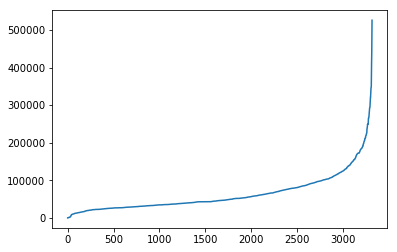

In [177]:
lengths = [len(text) for text in train_text['Text']]
plt.plot(sorted(lengths))

In [178]:
cv = cross_validation.KFold(len(train_text), n_folds=9)
results = []

lengths = numpy.asarray(lengths)

for train_range, test_range in cv:
    test_forest = forest.fit(lengths[:, None][train_range], train_variants['Class'][train_range])
    p = test_forest.predict_proba(lengths[:, None][test_range])
    log_loss = sklearn.metrics.log_loss(train_variants['Class'][test_range], p, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)
    
print("Results: %s" % str(numpy.array(results).mean()))

Log loss: 16.8450021104
Log loss: 14.5151659718
Log loss: 14.2950040449
Log loss: 16.3519412025
Log loss: 14.6694557827
Log loss: 12.8407828929
Log loss: 11.6047642741
Log loss: 17.3347657777
Log loss: 15.7058224314
Results: 14.9069671654


These results are surprisingly bad... perhaps the length of text does not predict the target class but is just a quirk of our data set. Regardless, let's at least give XGBoost a try.

In [179]:
model = XGBClassifier()
cv = cross_validation.KFold(len(train_text), n_folds=9)
results = []

lengths = numpy.asarray(lengths)

for train_range, test_range in cv:
    model.fit(lengths[:, None][train_range], train_variants['Class'][train_range])
    p = model.predict_proba(lengths[:, None][test_range])
    log_loss = sklearn.metrics.log_loss(train_variants['Class'][test_range], p, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)
    
print("Results: %s" % str(numpy.array(results).mean()))

Log loss: 1.87741617204
Log loss: 1.91402993018
Log loss: 1.84116874744
Log loss: 1.859539963
Log loss: 1.85289642372
Log loss: 1.61689549261
Log loss: 1.82134078867
Log loss: 2.10844119721
Log loss: 1.75650165333
Results: 1.84980337425


Much better here, but it may be overfitted.

Now that we have our individual models, lets combine them to reduce the variation and improve our results. We'll use a basic ensemble voting algorithm.

### Combining the Models

In [180]:
cv = cross_validation.KFold(len(train_variants), n_folds=3)
results = []

name_forest = RandomForestClassifier(n_estimators = 100)
letter_forest = RandomForestClassifier(n_estimators = 100)
location_model = XGBClassifier()
text_forest = RandomForestClassifier(n_estimators = 100)
length_model = XGBClassifier()

for train_range, test_range in cv:   
    test_name_forest = name_forest.fit(f_enc_gene.loc[train_range], train_variants['Class'][train_range])
    test_letter_forest = text_forest.fit(f_enc.loc[train_range], train_variants['Class'][train_range])
    test_length_model = length_model.fit(lengths[:, None][train_range], train_variants['Class'][train_range])
    test_text_forest = letter_forest.fit(vectors[train_range], train_variants['Class'][train_range])
    test_location_model = location_model.fit(l_value[:, None][train_range], train_variants['Class'][train_range])
    
    p1 = test_letter_forest.predict_proba(f_enc.loc[test_range])
    p2 = test_text_forest.predict_proba(vectors[test_range])
    p3 = test_length_forest.predict_proba(lengths[:, None][test_range]) 
    p4 = test_name_forest.predict_proba(f_enc_gene.loc[test_range])
    p5 = test_location_model.predict_proba(l_value[:, None][test_range])
    
    p_combined = [p1n + p2n + p3n + p4n + p5n / 5.0 for p1n, p2n, p3n, p4n, p5n in zip(p1, p2, p3, p4, p5)]
    log_loss = sklearn.metrics.log_loss(train_variants['Class'][test_range], p_combined, labels=[1, 2, 3, 4, 5, 6, 7, 8, 9])
    results.append(log_loss)
    print("Log loss: %s" % log_loss)

print("Results: %s" % str(numpy.array(results).mean()))

Log loss: 1.3199153312
Log loss: 1.33587428483
Log loss: 1.96157412263
Results: 1.53912124622


From here, the voting classifier could be improved on by tuning the weights applied to each classifier. For example, we know that the individual classifiers show different log loss averages after the cross validation of the model. We can use those relative values to begin to weight each set of predictions, and use that when averaging the results.

### Next Steps

There are a number of ways to improve these results if more time and computing resources are available. First of all, the text model could be greatly improved by stemming the inputs, adding more stopwords, and training the classifier. Additional information regarding the gene name labels (ex: BRCA1) could be found, processed, and added to our gene name classifier to make the model more sophisticated. Also, we've classified a large chunk of the gene variant information under a class "Other" - this data could be pre-processed much more carefully, including incorporating the variant description such as "Insertion", "Deletion", etc.

For each classifier, models more sophisticated than the random forest classifiers could be tried to find improvements. These models can be boosted if the computing resources are available, but may result in overfitting. Also, and perhaps most importantly, all of the hyperparameters for each stage of our pipeline could be tuned with a variety of techniques, to find the optimal number of trees, ideal stopping points, number of text features extracted, and even the random seed used for each algorithm.